In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydot

from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz

import time

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [2]:
train = pd.read_csv("data/train.csv")
Y = np.array(np.array(train["Cover_Type"].tolist()))
train = train.loc[:, train.columns != "Cover_Type"]
X = np.array(train)
feature_list = list(train.columns)
n = X.shape[0]

shuffle = np.random.permutation(np.arange(n))
X, Y = X[shuffle], Y[shuffle]

percent_in_dev = .2
dev_slice = int(percent_in_dev * n)

# Set some variables to dev and training data.
dev_dat, dev_lab = X[:dev_slice], Y[:dev_slice]
train_dat, train_lab = X[dev_slice:], Y[dev_slice:]

n_dev = dev_dat.shape[0]
n_train = train_dat.shape[0]
n_feat = train_dat.shape[1]

def binarizeY(data):
    binarized_data = np.zeros((data.size,10))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i]=1
    return binarized_data

train_lab_b = binarizeY(train_lab)
dev_lab_b = binarizeY(dev_lab)
n_class = train_lab_b[1].size

print(f'Dev size: {n_dev}')
print(f'Train size: {n_train}')
print(f'Features: {n_feat}')
print(f'Classes: {n_class}')
pd.DataFrame(train_dat).describe()

Dev size: 3024
Train size: 12096
Features: 55
Classes: 10


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,...,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,7527.118800,2751.081267,156.782821,16.483052,228.625165,51.281581,1707.330357,212.861690,218.987186,134.955936,...,0.022239,0.045883,0.040179,0.001571,0.006614,0.000661,0.001984,0.050761,0.043320,0.029266
std,4362.528179,416.896151,110.093786,8.443301,211.421953,61.433674,1319.372015,30.392477,22.776599,45.787111,...,0.147465,0.209240,0.196386,0.039603,0.081059,0.025710,0.044501,0.219517,0.203585,0.168558
min,1.000000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,58.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3734.500000,2378.000000,65.000000,10.000000,67.000000,5.000000,755.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7513.500000,2753.500000,126.000000,15.000000,180.000000,33.000000,1310.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11283.250000,3105.000000,261.000000,22.000000,330.000000,79.000000,2263.250000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15119.000000,3849.000000,360.000000,50.000000,1318.000000,554.000000,6836.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
train_dat = normalize(train_dat, axis=0, norm='max')
dev_dat = normalize(dev_dat, axis=0, norm='max')
pd.DataFrame(train_dat).describe()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,...,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,0.497858,0.714752,0.435508,0.329661,0.173464,0.092566,0.249756,0.838038,0.862154,0.544177,...,0.022239,0.045883,0.040179,0.001571,0.006614,0.000661,0.001984,0.050761,0.043320,0.029266
std,0.288546,0.108313,0.305816,0.168866,0.160411,0.110891,0.193004,0.119655,0.089672,0.184625,...,0.147465,0.209240,0.196386,0.039603,0.081059,0.025710,0.044501,0.219517,0.203585,0.168558
min,0.000066,0.484022,0.000000,0.000000,0.000000,-0.263538,0.000000,0.228346,0.389764,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.247007,0.617823,0.180556,0.200000,0.050835,0.009025,0.110445,0.771654,0.814961,0.427419,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.496957,0.715381,0.350000,0.300000,0.136571,0.059567,0.191633,0.866142,0.877953,0.556452,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.746296,0.806703,0.725000,0.440000,0.250379,0.142599,0.331078,0.925197,0.925197,0.673387,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

start_time = time.time()
rf.fit(train_dat, train_lab)
print(f'Train time = {time.time() - start_time}')

start_time = time.time()
rf_pred = rf.predict(dev_dat).astype(int)
print(f'Train time = {time.time() - start_time}')

Train time = 99.53985261917114
Train time = 0.6649689674377441


,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.590566,0.540909,0.461648,0.292162,0.049096,0.0,0.971014,0.360119,0.415056,0.406870
recall,0.712984,0.289538,0.777512,0.561644,0.044393,0.0,0.159905,0.360119,0.363711,0.360119
f1-score,0.646027,0.377179,0.579323,0.384375,0.046626,0.0,0.274590,0.360119,0.329731,0.325446
support,439.000000,411.000000,418.000000,438.000000,428.000000,471.0,419.000000,0.360119,3024.000000,3024.000000


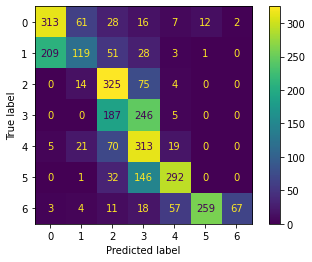

In [5]:
cm = confusion_matrix(dev_lab, rf_pred)

ConfusionMatrixDisplay(cm).plot()

pd.DataFrame(classification_report(dev_lab, rf_pred, output_dict=True))

In [6]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')